# Implementing a denoising autoencoder

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

In this exercise we will develop a denoising autoencoder, and test it out on the MNIST dataset.

In [2]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `DenoisingAutoencoder` in the file `METU/denoising_autoencoder.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [3]:
from METU.denoising_autoencoder import DenoisingAutoencoder
from METU.Noise import Noise, GaussianNoise

# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 2
num_inputs = 100
# Outputs are equal to the inputs
network_size = (input_size, hidden_size, input_size)

def init_toy_model(num_inputs, input_size):
  np.random.seed(0)
  net = DenoisingAutoencoder((input_size, hidden_size, input_size))
  net.init_weights()
  return net

def init_toy_data(num_inputs, input_size):
  np.random.seed(1)
  X = np.random.randn(num_inputs, input_size)
  return X

net = init_toy_model(num_inputs, input_size)
X = init_toy_data(num_inputs, input_size)
print "Ok, now we have a toy network"

Ok, now we have a toy network


# Forward pass: compute loss
Open the file `METU/denoising_autoencoder.py` and look at the method `DenoisingAutoencoder.loss`. This function is very similar to the loss functions you have written in the first HW: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for the corrupted input. In the same function, implement the second part that computes the data and the regularization losses.

In [4]:
loss,_ = net.loss(GaussianNoise(0.5)(X), X, reg=3e-3, activation_function='sigmoid')

correct_loss = 2.42210627243
print 'Your loss value:' + str(loss)

print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Your loss value:2.42210627243
Difference between your loss and correct loss:
3.02424751908e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [6]:
from METU.gradient_check import eval_numerical_gradient

reg = 3e-3

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

net.init_weights()
noisy_X = GaussianNoise(0.5)(X)
loss, grads = net.loss(noisy_X, X, reg, activation_function='tanh')

# these should all be less than 1e-5 or so
f = lambda W: net.loss(noisy_X, X, reg, activation_function='tanh')[0]
W1_grad = eval_numerical_gradient(f, net.weights[1]['W'], verbose=False)
print '%s max relative error: %e' % ("W1", rel_error(W1_grad, grads[1]['W']))
W0_grad = eval_numerical_gradient(f, net.weights[0]['W'], verbose=False)
print '%s max relative error: %e' % ("W0", rel_error(W0_grad, grads[0]['W']))
b1_grad = eval_numerical_gradient(f, net.weights[1]['b'], verbose=False)
print '%s max relative error: %e' % ("b1", rel_error(b1_grad, grads[1]['b']))
b0_grad = eval_numerical_gradient(f, net.weights[0]['b'], verbose=False)
print '%s max relative error: %e' % ("b0", rel_error(b0_grad, grads[0]['b']))

W1 max relative error: 3.924541e-06
W0 max relative error: 2.068371e-05
b1 max relative error: 1.625133e-06
b0 max relative error: 4.235983e-06


# Train the network
To train the network we will use stochastic gradient descent (SGD). Look at the function `DenoisingAutoencoder.train_with_SGD` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedures you used in the first HW. 

Once you have implemented the method, run the code below to train the network on toy data. You should achieve a training loss less than 2.0.

Final training loss:  1.89964078184


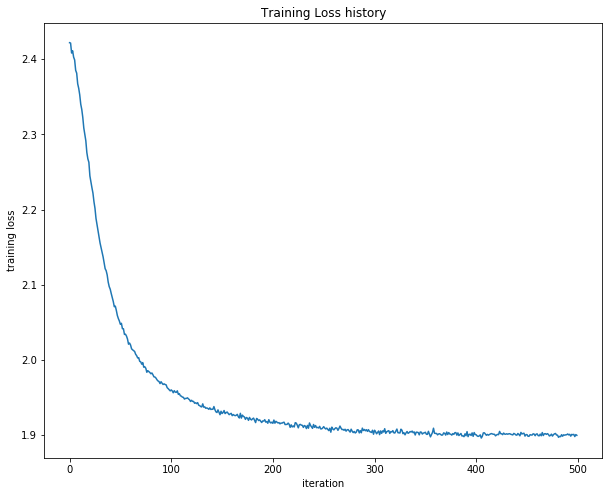

In [7]:
net = init_toy_model(num_inputs, input_size)
reg = 3e-3
stats = net.train_with_SGD(X, noise=GaussianNoise(sd=0.5),
            learning_rate=0.02, learning_rate_decay=0.95, 
            reg=reg, batchsize=100, num_iters=500, verbose=False, activation_function='sigmoid')

print 'Final training loss: ', stats['loss_history'][-1]
# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a DAE network that passes gradient checks and works on toy data, it's time to load up the MNIST dataset so we can use it to train DAE on a real dataset. Make sure that you have run "cs231n/datasets/get_datasets.sh" script before you continue with this step.

In [8]:
from cs231n.data_utils import load_mnist

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
    
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


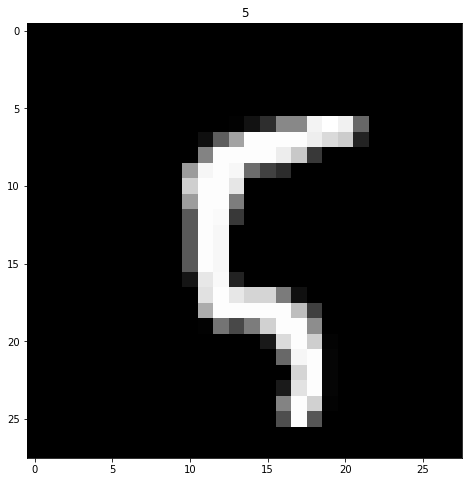

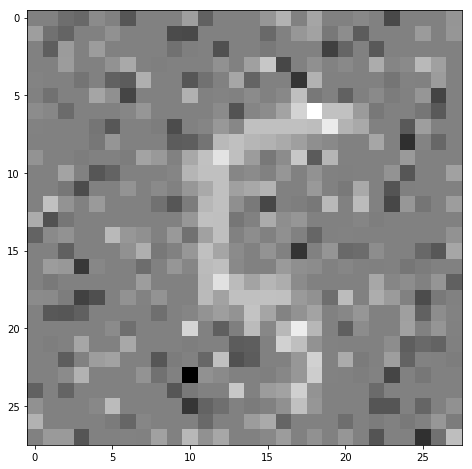

In [9]:
#Visualize some samples

x = np.reshape(X_train[100], (28,28))

plt.imshow(x)
plt.title(y_train[0])
plt.show()

plt.imshow(GaussianNoise(rate=0.5,sd=0.5)(x))
plt.show()
# Yes, DAE will learn to reconstruct from such corrupted data

# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [27]:
import time

input_size = 28 * 28
hidden_size = 300 # Try also sizes bigger than 28*28

reg = 0.003 # 3e-3

net = DenoisingAutoencoder((input_size, hidden_size, input_size))
net.init_weights()

# Train with SGD
tic = time.time()
stats = net.train_with_SGD(X_train, noise=GaussianNoise(rate=0.5,sd=0.5),
            learning_rate=0.4, learning_rate_decay=0.99, 
            reg=reg, num_iters=1000, batchsize=128, momentum='classic', mu=0.9, verbose=True, 
            activation_function='sigmoid')
toc = time.time()
print toc-tic, 'sec elapsed'

SGD: iteration 0 / 1000: loss 93.550670
SGD: iteration 10 / 1000: loss 30.997792
SGD: iteration 20 / 1000: loss 30.584602
SGD: iteration 30 / 1000: loss 27.908739
SGD: iteration 40 / 1000: loss 25.428982
SGD: iteration 50 / 1000: loss 21.797228
SGD: iteration 60 / 1000: loss 20.248228
SGD: iteration 70 / 1000: loss 17.522115
SGD: iteration 80 / 1000: loss 16.414086
SGD: iteration 90 / 1000: loss 15.624582
SGD: iteration 100 / 1000: loss 14.013777
SGD: iteration 110 / 1000: loss 13.837599
SGD: iteration 120 / 1000: loss 13.248417
SGD: iteration 130 / 1000: loss 12.393534
SGD: iteration 140 / 1000: loss 12.688987
SGD: iteration 150 / 1000: loss 12.179300
SGD: iteration 160 / 1000: loss 11.912695
SGD: iteration 170 / 1000: loss 11.749227
SGD: iteration 180 / 1000: loss 11.162249
SGD: iteration 190 / 1000: loss 11.157434
SGD: iteration 200 / 1000: loss 10.872505
SGD: iteration 210 / 1000: loss 10.769808
SGD: iteration 220 / 1000: loss 11.011998
SGD: iteration 230 / 1000: loss 10.766342
SGD

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

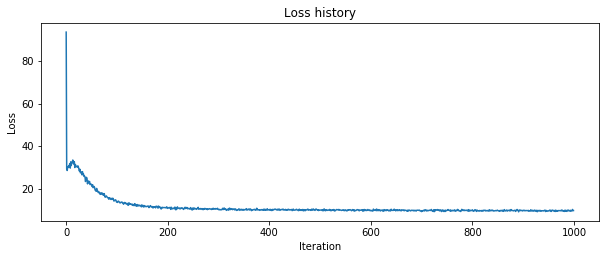

In [28]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()

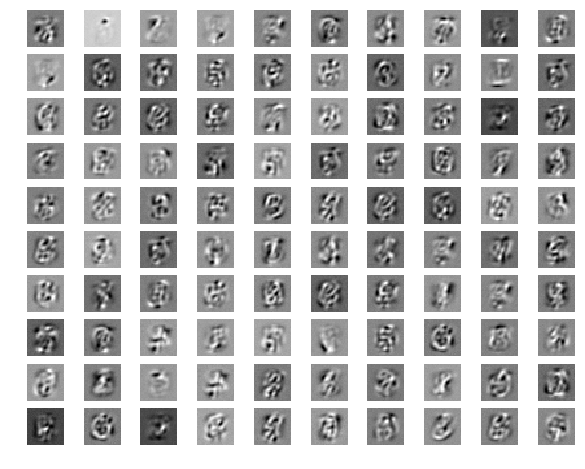

In [29]:
#from cs231n.vis_utils import visualize_grid
#from cs231n.vis_utils import visualize_grid_2D

# SHOW SOME WEIGHTS
W0 = net.weights[0]['W']
W0 = W0.T
num_of_samples=100
for i in range(0,10):
    for j in range(0,10):
        plt.subplot(10, 10, i*10+j+1)
        rand_index = np.random.randint(0,W0.shape[0]-1,1)
        plt.imshow(W0[rand_index].reshape(28,28))
        plt.axis('off')
plt.show()

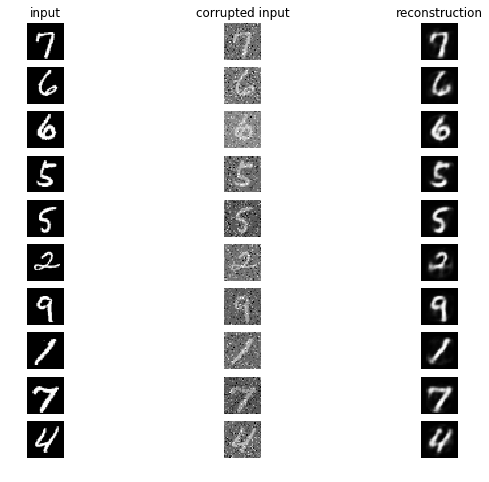

In [32]:
# SHOW SOME RECONSTRUCTIONS
plt_index=1
for i in range(0,10):
    rand_index = np.random.randint(0,X_train.shape[0]-1,1)
    x = X_train[rand_index]
    x_noisy = GaussianNoise(rate=0.5,sd=0.5)(x)
    x_recon = net.predict(x_noisy)
    #x_loss,_ = net.loss(x_noisy, x, reg=0.0, activation_function='sigmoid')
    
    plt.subplot(10,3,plt_index)
    plt.imshow(x.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('input')
    plt_index+=1
    plt.subplot(10,3,plt_index)
    plt.imshow(x_noisy.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('corrupted input')
    plt_index+=1
    plt.subplot(10,3,plt_index)
    plt.imshow(x_recon.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('reconstruction')
    plt_index+=1

# Tune your hyperparameters

**What's wrong?**. Look at the visualizations above and try to come up with strategies for improving your training. With some effort, I came up with the following weights (which are also not perfect) and reconstructions (which are quite good):

<img src="dae_learned_representation.png">

<img src="dae_learned_representation_demo.png">
